# analysis_senseboard – Statistical Exploration with SenseBoard Loadcell Data

This notebook extends the statistical analysis to **all_data_enriched.csv**, incorporating the additional **SenseBoard loadcell signals** (forces, moments, pressures).  
The objective is to assess whether loadcell-derived metrics improve our understanding of performance, still using **SOG** as the main outcome.

## Workflow

1. **Data preparation**
   - Load `all_data_enriched.csv`.
   - Restrict analysis to rows where `boat_name == "SenseBoard"` (only SenseBoard carries loadcells).
   - Remove SenseBoard rows without loadcell values (all NaN).
   - Drop non-informative or redundant columns (`drop_cols`).
   - Keep only numeric features and drop rows with missing `SOG`.
   - Apply missing-data filter: exclude variables with more than 20% NaN.

2. **Global analysis**
   - Apply `full_analysis(...)`, which:
     - Cleans features and samples.
     - Computes correlations between all signals (including loadcells) and **SOG**.
     - Performs **ANOVA** to rank feature influence.
     - Fits a **linear regression model** to estimate coefficients and identify the strongest predictors of speed.

3. **Upwind analysis (TWA ≥ 0)**
   - **All upwind runs**: overall SenseBoard + navigation signals vs. SOG.
   - **Rider split**:
     - Gian’s upwind runs = SenseBoard paired against Karl.
     - Karl’s upwind runs = SenseBoard paired against Gian.
     - Compare Gian vs. Karl SOG distributions with a **t-test**.
   - **Role split**:
     - Master vs. Slave roles analyzed separately with `full_analysis(...)`.
     - Compared with a **t-test**.

4. **Downwind analysis (TWA < 0)**
   - **All downwind runs**: feature importance on SOG.
   - **Rider split**:
     - Gian vs. Karl subsets (SenseBoard rows filtered by opponent).
     - Compared with a **t-test**.
   - **Role split**:
     - Master vs. Slave roles analyzed separately with `full_analysis(...)`.
     - Compared with a **t-test**.


In [1]:
from analysis import *

drop_cols = [
    "TWD","COG","TWA", "TimeUTC", "SecondsSince1970", "ISODateTimeUTC","Latitude","Longitude","Euler_X (deg)","Euler_Y (deg)",
    "Lat", "LatBow", "LatCenter", "LatStern", "Lon", "LonBow", "LonCenter", "LonStern",
    "Leg", "Log", "LogAlongCourse", "MagneticVariation", "Rank", "TimeLocal",
    "DistanceToLeader", "interval_id", "boat_name", "interval_duration",
    "Heel", "Heel_Lwd", "Line_R", "Line_L", "BelowLineCalc", "VMC","XTE","VMG","gain_forward","gain_lateral", "gain_vmg","Total_lines", "LoadCell_1","LoadCell_2","LoadCell_3","LoadCell_4","LoadCell_5","LoadCell_6","M_tot_X","M_tot_Y","M_front_X","M_front_Y","M_back_X","M_back_Y","P_front_X","P_front_Y","P_back_X","P_back_Y","Side_lines","total_line2","Line_R2","Line_L2","Line_C"
]

MAX_NULL_RATIO = 0.2


In [2]:
df = pd.read_csv("all_data_enriched.csv")
df = df[df["boat_name"] == "SenseBoard"].copy()
load_cell_cols = ["LoadCell_1", "LoadCell_2", "LoadCell_3", "LoadCell_4", "LoadCell_5", "LoadCell_6"]
df = df.dropna(subset=load_cell_cols, how='all')
df.sample(10)

,ISODateTimeUTC,SecondsSince1970,Heel_Abs,Heel_Lwd,Lat,LatBow,LatCenter,LatStern,Leg,Line_C,...,M_tot_X,M_tot_Y,M_front_X,M_front_Y,M_back_X,M_back_Y,P_front_X,P_front_Y,P_back_X,P_back_Y
64057,2025-06-10 12:44:45.460000+00:00,1.749559e+09,47.2,47.2,43.532343,43.532341,43.532347,43.532353,NaN,121.0,...,8044.473200,5286.535033,5538.562358,753.853015,2505.910842,-377.633106,24.355868,-178.942703,-8.179320,-54.276618
61940,2025-06-10 12:37:24.856000+00:00,1.749559e+09,58.1,58.1,43.530915,43.530913,43.530919,43.530924,NaN,115.6,...,12354.659687,2483.655809,8124.842474,2172.710753,4229.817214,-968.962779,50.024200,-187.065280,-19.534163,-85.272562
53056,2025-06-09 13:19:01.453000+00:00,1.749475e+09,42.2,42.2,43.504899,43.504901,43.504895,43.504889,NaN,5.5,...,-4899.593434,3122.691123,-1729.576048,-286.867085,-3170.017387,-1249.831482,-10.938520,65.950409,-28.736283,72.885440
49744,2025-06-09 13:06:00.062000+00:00,1.749474e+09,55.4,55.4,43.504733,43.504732,43.504738,43.504744,NaN,7.7,...,7382.587080,-27.363306,5075.778706,872.665661,2306.808374,-667.476996,32.731646,-190.380574,-23.454719,-81.059786
73663,2025-06-10 13:25:43.656000+00:00,1.749562e+09,54.9,54.9,43.531929,43.531931,43.531925,43.531918,NaN,116.9,...,-1732.856697,4841.293657,-324.349279,103.402823,-1408.507418,-1011.508413,2.942408,9.229611,-18.391431,25.609740
75207,2025-06-10 13:33:30.852000+00:00,1.749562e+09,48.4,48.4,43.531515,43.531514,43.531520,43.531526,NaN,136.5,...,9375.226637,3396.829086,6072.040605,1002.663664,3303.186032,-929.808977,27.455831,-166.270034,-19.033706,-67.618050
39564,2025-06-07 13:27:02.266000+00:00,1.749303e+09,58.8,58.8,43.518668,43.518667,43.518672,43.518676,NaN,106.7,...,8812.136332,-2939.301685,6618.335658,1749.742536,2193.800674,-667.640614,54.572340,-206.417835,-28.725744,-94.389938
53861,2025-06-09 13:24:45.244000+00:00,1.749475e+09,54.4,54.4,43.507662,43.507660,43.507667,43.507673,NaN,5.5,...,8799.139391,959.995204,5487.596601,847.340798,3311.542790,-831.010027,25.474920,-164.982127,-21.286677,-84.826586
37125,2025-06-07 13:12:33.845000+00:00,1.749302e+09,26.5,26.5,43.518008,43.518010,43.518005,43.517999,1.0,90.5,...,-3238.276084,265.350074,-2188.236981,408.591619,-1050.039103,-619.398901,17.463693,93.527857,-22.722336,38.520154
29279,2025-06-07 12:36:22.953000+00:00,1.749300e+09,48.7,48.7,43.518100,43.518099,43.518103,43.518107,1.0,4.7,...,6921.816838,-47.636062,5442.101870,874.344323,1479.714968,-309.008108,34.378778,-213.980700,-12.179397,-58.322211


## I. All together

In [3]:
# Select numeric columns
df_numeric = df.select_dtypes(include=["float64", "int64"]).copy()
# Drop specified columns
df_numeric.drop(columns=[c for c in drop_cols if c in df_numeric.columns], inplace=True)

# Drop rows where 'SOG' is missing
df_numeric.dropna(subset=["SOG"], inplace=True)


# Print summary
print(f"Variables utilisées: {df_numeric.columns.tolist()}")
print(f"Number of rows after filtering: {len(df_numeric)}")



Variables utilisées: ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'SOG', 'boat_weight', 'Line_C2', 'side_line2', 'F_front', 'F_back']
Number of rows after filtering: 30546



Initial features (10): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2', 'F_front', 'F_back']

Selected features (10): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2', 'F_front', 'F_back']

Data cleaning:
- Initial samples: 30546
- Removed samples with NaNs: 225
- Final samples: 30321

Correlation with SOG:


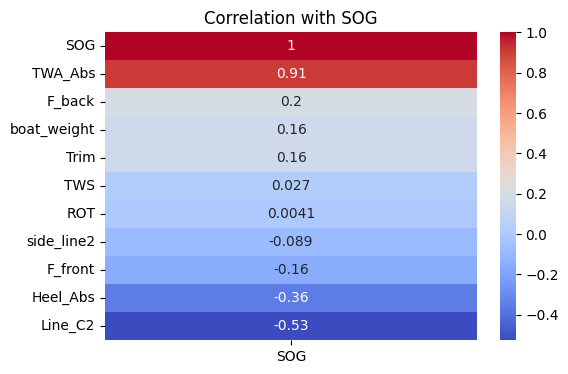


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
TWA_Abs,68101.923377,1.0,90420.693582,0.000000e+00,0.748945
boat_weight,2087.527683,1.0,2771.664758,0.000000e+00,0.083783
TWS,1557.345039,1.0,2067.727482,0.000000e+00,0.063863
Line_C2,582.324040,1.0,773.166762,4.756459e-168,0.024874
F_front,561.326187,1.0,745.287367,3.899772e-162,0.023999
Trim,466.584829,1.0,619.496803,2.207336e-135,0.020029
Heel_Abs,107.640542,1.0,142.917145,7.266098e-33,0.004693
side_line2,64.426752,1.0,85.541073,2.413675e-20,0.002814
ROT,22.921041,1.0,30.432862,3.484443e-08,0.001003
F_back,6.061193,1.0,8.047604,4.559409e-03,0.000265



Polynomial fit:
R²: 0.860

Top coefficients:
    feature  coefficient
        TWS     0.191425
boat_weight     0.070167
    TWA_Abs     0.051558
       Trim    -0.043821
 side_line2    -0.015115
    Line_C2     0.013070
   Heel_Abs     0.010968
        ROT     0.001485
    F_front     0.000022
     F_back     0.000001


,feature,coefficient
4,TWS,0.191425
5,boat_weight,0.070167
3,TWA_Abs,0.051558
2,Trim,-0.043821
7,side_line2,-0.015115
6,Line_C2,0.013070
0,Heel_Abs,0.010968
1,ROT,0.001485
8,F_front,0.000022
9,F_back,0.000001


In [4]:
full_analysis(df_numeric, target_variable="SOG",max_null_ratio= MAX_NULL_RATIO)

## II Upwind:

### II.1. All upwind data

In [5]:
upwind_data = df[df['TWA'] >= 0]
df_numeric_upwind = upwind_data.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_upwind.drop(columns=[c for c in drop_cols if c in df_numeric_upwind.columns], inplace=True)
df_numeric_upwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_upwind)}")

Number of rows after filtering: 18876


In [6]:
print(upwind_data['boat_name'].unique())
print(upwind_data['opponent_name'].unique())
print(upwind_data['TWA'].mean())

['SenseBoard']
['Karl Maeder' 'Gian Stragiotti']
48.36674316592499



Initial features (10): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2', 'F_front', 'F_back']

Selected features (10): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2', 'F_front', 'F_back']

Data cleaning:
- Initial samples: 18876
- Removed samples with NaNs: 142
- Final samples: 18734

Correlation with SOG:


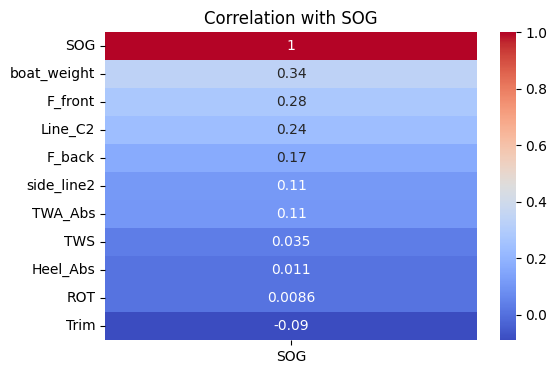


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
boat_weight,1600.325508,1.0,2888.738474,0.000000e+00,0.133665
F_front,1227.239618,1.0,2215.283255,0.000000e+00,0.105801
Line_C2,240.469045,1.0,434.069306,2.548005e-95,0.022658
TWS,202.274046,1.0,365.123730,1.262694e-80,0.019128
Trim,157.836862,1.0,284.910423,1.882946e-63,0.014989
TWA_Abs,156.088781,1.0,281.754971,8.957497e-63,0.014825
side_line2,147.224665,1.0,265.754406,2.449162e-59,0.013995
F_back,16.403419,1.0,29.609719,5.350259e-08,0.001579
ROT,9.153097,1.0,16.522202,4.828007e-05,0.000882
Heel_Abs,7.416084,1.0,13.386731,2.541062e-04,0.000714



Polynomial fit:
R²: 0.279

Top coefficients:
    feature  coefficient
        TWS     0.095676
boat_weight     0.077892
       Trim    -0.032105
 side_line2    -0.028136
    TWA_Abs     0.017664
    Line_C2     0.010091
   Heel_Abs    -0.003838
        ROT     0.001148
    F_front     0.000039
     F_back    -0.000003


,feature,coefficient
4,TWS,0.095676
5,boat_weight,0.077892
2,Trim,-0.032105
7,side_line2,-0.028136
3,TWA_Abs,0.017664
6,Line_C2,0.010091
0,Heel_Abs,-0.003838
1,ROT,0.001148
8,F_front,0.000039
9,F_back,-0.000003


In [7]:
full_analysis(df_numeric_upwind, target_variable="SOG",max_null_ratio= MAX_NULL_RATIO)

### II.2. Upwind: Gian vs Karl
#### II.2.1. Upwind: Gian

In [8]:
gian_data_upwind = upwind_data[((upwind_data['boat_name'] == "SenseBoard") & (upwind_data['opponent_name'] == "Karl Maeder"))]
df_numeric_gian_upwind = gian_data_upwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_gian_upwind.drop(columns=[c for c in drop_cols if c in df_numeric_gian_upwind.columns], inplace=True)
df_numeric_gian_upwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_gian_upwind)}")

Number of rows after filtering: 13275


In [9]:
print(gian_data_upwind['boat_name'].unique())
print(gian_data_upwind['opponent_name'].unique())
print(gian_data_upwind['TWA'].mean())

['SenseBoard']
['Karl Maeder']
48.03460655367232



Initial features (10): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2', 'F_front', 'F_back']

Selected features (10): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2', 'F_front', 'F_back']

Data cleaning:
- Initial samples: 13275
- Removed samples with NaNs: 99
- Final samples: 13176

Correlation with SOG:


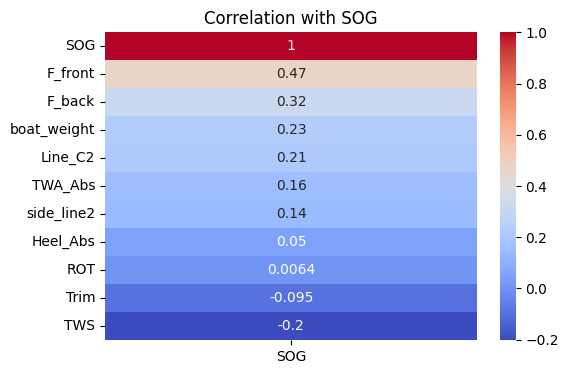


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
F_front,1109.434857,1.0,2012.780147,0.000000e+00,0.132614
boat_weight,308.620266,1.0,559.910967,2.933987e-121,0.040795
side_line2,162.328825,1.0,294.503309,2.660411e-65,0.021881
Trim,92.166812,1.0,167.212638,5.121207e-38,0.012542
Line_C2,73.841442,1.0,133.966035,7.836268e-31,0.010073
TWA_Abs,61.465227,1.0,111.512621,5.802450e-26,0.008399
TWS,27.139015,1.0,49.236663,2.379716e-12,0.003726
ROT,5.751742,1.0,10.435036,1.239507e-03,0.000792
F_back,3.377773,1.0,6.128088,1.331756e-02,0.000465
Heel_Abs,1.217464,1.0,2.208771,1.372519e-01,0.000168



Polynomial fit:
R²: 0.290

Top coefficients:
    feature  coefficient
boat_weight     0.074954
        TWS     0.046670
 side_line2    -0.034025
       Trim    -0.029309
    TWA_Abs     0.013965
    Line_C2     0.006770
   Heel_Abs    -0.001875
        ROT     0.001044
    F_front     0.000045
     F_back    -0.000002


,feature,coefficient
5,boat_weight,0.074954
4,TWS,0.046670
7,side_line2,-0.034025
2,Trim,-0.029309
3,TWA_Abs,0.013965
6,Line_C2,0.006770
0,Heel_Abs,-0.001875
1,ROT,0.001044
8,F_front,0.000045
9,F_back,-0.000002


In [10]:
full_analysis(df_numeric_gian_upwind, target_variable="SOG",max_null_ratio= MAX_NULL_RATIO)

#### II.2.2. Upwind: Karl

In [11]:
karl_data_upwind = upwind_data[((upwind_data['boat_name'] == "SenseBoard") & (upwind_data['opponent_name'] == "Gian Stragiotti"))]
df_numeric_karl_upwind = karl_data_upwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_karl_upwind.drop(columns=[c for c in drop_cols if c in df_numeric_karl_upwind.columns], inplace=True)
df_numeric_karl_upwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_karl_upwind)}")
print(df_numeric_karl_upwind.shape)
print(df_numeric_karl_upwind.columns)

Number of rows after filtering: 5601
(5601, 11)
Index(['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'SOG', 'boat_weight',
       'Line_C2', 'side_line2', 'F_front', 'F_back'],
      dtype='object')


In [12]:
print(karl_data_upwind['boat_name'].unique())
print(karl_data_upwind['opponent_name'].unique())
print(karl_data_upwind['TWA'].mean())

['SenseBoard']
['Gian Stragiotti']
49.153944295661496


In [13]:
df_numeric_karl_upwind.head(10)

,Heel_Abs,ROT,Trim,TWA_Abs,TWS,SOG,boat_weight,Line_C2,side_line2,F_front,F_back
25553,59.5,11.000,7.5,41.174,9.352,21.4,102.89,93.3,6.300,27567.598622,24661.188272
25555,57.4,-14.141,12.3,42.564,9.372,21.4,102.89,88.1,13.800,30282.257552,24532.446152
25557,59.8,1.020,8.7,42.454,9.391,21.3,102.89,98.4,18.300,30629.872010,26538.607253
25560,57.8,15.000,1.5,40.944,9.411,21.4,102.89,108.1,11.900,29534.445709,25671.679650
25562,53.0,-7.619,4.6,41.734,9.432,21.4,102.89,111.4,10.688,31969.060202,27080.840797
25563,54.8,-10.309,7.0,42.724,9.452,21.4,102.89,111.3,11.600,32674.719191,26459.098753
25565,54.6,11.224,7.0,41.614,9.471,21.3,102.89,110.7,12.000,34743.378192,26875.356725
25567,47.0,-19.802,6.2,43.604,9.492,21.4,102.89,109.9,12.600,34743.378192,26875.356725
25569,41.2,7.000,4.4,42.894,9.506,21.3,102.89,107.5,11.600,30655.266332,26253.937186
25571,51.7,1.000,8.5,42.784,9.516,21.4,102.89,104.6,11.296,30655.266332,26253.937186



Initial features (10): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2', 'F_front', 'F_back']

Selected features (10): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2', 'F_front', 'F_back']

Data cleaning:
- Initial samples: 5601
- Removed samples with NaNs: 43
- Final samples: 5558

Correlation with SOG:


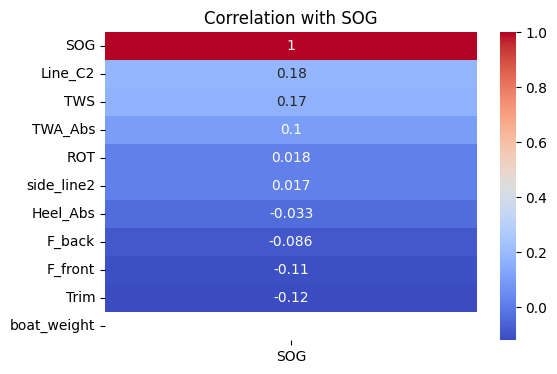


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
boat_weight,3862.909061,1.0,8278.781006,0.000000e+00,0.598750
TWA_Abs,227.769158,1.0,488.142732,9.610322e-104,0.080870
TWS,183.393343,1.0,393.038847,1.441157e-84,0.066157
Trim,72.434166,1.0,155.237047,3.658932e-35,0.027219
Line_C2,45.426369,1.0,97.355374,8.913731e-23,0.017245
F_back,13.697999,1.0,29.356822,6.274281e-08,0.005264
ROT,6.751685,1.0,14.469852,1.439518e-04,0.002601
Heel_Abs,2.278306,1.0,4.882745,2.716713e-02,0.000879
F_front,2.043854,1.0,4.380279,3.640235e-02,0.000789
side_line2,1.064206,1.0,2.280750,1.310454e-01,0.000411



Polynomial fit:
R²: 0.149

Top coefficients:
    feature   coefficient
        TWS  2.148812e-01
       Trim -4.048043e-02
    TWA_Abs  3.779673e-02
    Line_C2  8.851850e-03
 side_line2 -5.018746e-03
   Heel_Abs  3.933176e-03
        ROT  2.029365e-03
     F_back  4.803289e-06
    F_front -3.999961e-06
boat_weight -9.714451e-17


,feature,coefficient
4,TWS,2.148812e-01
2,Trim,-4.048043e-02
3,TWA_Abs,3.779673e-02
6,Line_C2,8.851850e-03
7,side_line2,-5.018746e-03
0,Heel_Abs,3.933176e-03
1,ROT,2.029365e-03
9,F_back,4.803289e-06
8,F_front,-3.999961e-06
5,boat_weight,-9.714451e-17


In [14]:
full_analysis(df_numeric_karl_upwind, target_variable="SOG",max_null_ratio= MAX_NULL_RATIO)

#### II.2.3. Upwind: Karl vs Gian t_test

In [15]:
t_test(df_numeric_gian_upwind,df_numeric_karl_upwind)

T-statistic: 39.897, p-value: 0.000000000000000
The difference is statistically significant, keeping data split.


### II.3. Upwind: Master vs Slave
#### II.3.1. Master

In [16]:
master_data_upwind = upwind_data[upwind_data['boat_role'] == "master"]
df_numeric_master_upwind = master_data_upwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_master_upwind.drop(columns=[c for c in drop_cols if c in df_numeric_master_upwind.columns], inplace=True)
df_numeric_master_upwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_master_upwind)}")

Number of rows after filtering: 9638



Initial features (10): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2', 'F_front', 'F_back']

Selected features (10): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2', 'F_front', 'F_back']

Data cleaning:
- Initial samples: 9638
- Removed samples with NaNs: 84
- Final samples: 9554

Correlation with SOG:


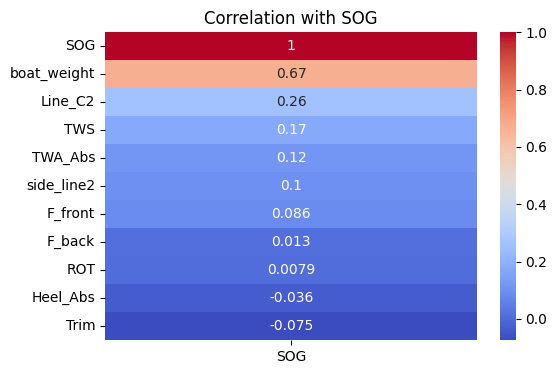


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
boat_weight,2522.769677,1.0,6479.723564,0.000000e+00,0.404408
F_front,245.827711,1.0,631.407467,5.647008e-135,0.062058
Line_C2,76.314249,1.0,196.012835,4.222797e-44,0.020127
Trim,43.385311,1.0,111.434992,6.599565e-26,0.011542
side_line2,42.315585,1.0,108.687406,2.597817e-25,0.011261
TWS,35.641813,1.0,91.545851,1.362628e-21,0.009502
TWA_Abs,17.981568,1.0,46.185583,1.139995e-11,0.004816
Heel_Abs,12.263267,1.0,31.498151,2.052088e-08,0.003290
F_back,0.118563,1.0,0.304528,5.810705e-01,0.000032
ROT,0.085028,1.0,0.218394,6.402767e-01,0.000023



Polynomial fit:
R²: 0.518

Top coefficients:
    feature   coefficient
boat_weight  1.530784e-01
        TWS  5.796156e-02
       Trim -2.364930e-02
 side_line2 -2.126477e-02
    TWA_Abs -9.799603e-03
    Line_C2  7.988773e-03
   Heel_Abs -6.830808e-03
        ROT -1.636994e-04
    F_front  2.629637e-05
     F_back -3.357086e-07


,feature,coefficient
5,boat_weight,1.530784e-01
4,TWS,5.796156e-02
2,Trim,-2.364930e-02
7,side_line2,-2.126477e-02
3,TWA_Abs,-9.799603e-03
6,Line_C2,7.988773e-03
0,Heel_Abs,-6.830808e-03
1,ROT,-1.636994e-04
8,F_front,2.629637e-05
9,F_back,-3.357086e-07


In [17]:
full_analysis(df_numeric_master_upwind, target_variable="SOG",max_null_ratio= MAX_NULL_RATIO)

#### II.3.2 Slave

In [18]:
slave_data_upwind = upwind_data[upwind_data['boat_role'] == "slave"]
df_numeric_slave_upwind = slave_data_upwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_slave_upwind.drop(columns=[c for c in drop_cols if c in df_numeric_slave_upwind.columns], inplace=True)
df_numeric_slave_upwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_slave_upwind)}")

Number of rows after filtering: 9238



Initial features (10): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2', 'F_front', 'F_back']

Selected features (10): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2', 'F_front', 'F_back']

Data cleaning:
- Initial samples: 9238
- Removed samples with NaNs: 58
- Final samples: 9180

Correlation with SOG:


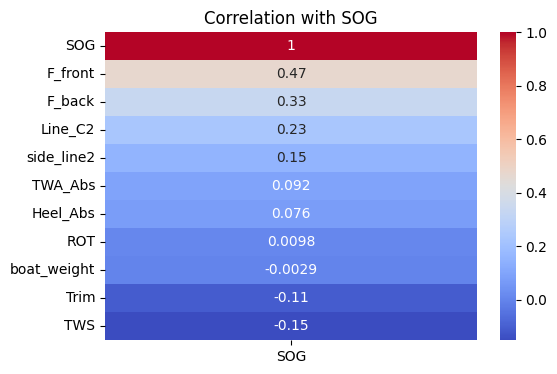


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
F_front,763.525804,1.0,1549.866105,2.444075e-313,0.144592
Line_C2,129.698139,1.0,263.271718,2.152196e-58,0.027912
side_line2,84.916102,1.0,172.369536,5.048516e-39,0.018452
Trim,64.926421,1.0,131.792872,2.673718e-30,0.014170
boat_weight,24.621091,1.0,49.977871,1.668561e-12,0.005421
TWS,17.387040,1.0,35.293612,2.938886e-09,0.003834
Heel_Abs,5.193220,1.0,10.541615,1.171358e-03,0.001148
F_back,3.504905,1.0,7.114538,7.659562e-03,0.000775
TWA_Abs,1.772997,1.0,3.598971,5.784672e-02,0.000392
ROT,0.339349,1.0,0.688838,4.065817e-01,0.000075



Polynomial fit:
R²: 0.270

Top coefficients:
    feature  coefficient
        TWS    -0.043919
 side_line2    -0.030735
       Trim    -0.029465
boat_weight     0.014517
    Line_C2     0.010735
   Heel_Abs    -0.004680
    TWA_Abs     0.002684
        ROT     0.000301
    F_front     0.000045
     F_back    -0.000002


,feature,coefficient
4,TWS,-0.043919
7,side_line2,-0.030735
2,Trim,-0.029465
5,boat_weight,0.014517
6,Line_C2,0.010735
0,Heel_Abs,-0.004680
3,TWA_Abs,0.002684
1,ROT,0.000301
8,F_front,0.000045
9,F_back,-0.000002


In [19]:
full_analysis(df_numeric_slave_upwind, target_variable="SOG",max_null_ratio= MAX_NULL_RATIO)

#### III.3.3. Upwind: Master vs Slave t_test

In [20]:
t_test(df_numeric_master_upwind,df_numeric_slave_upwind)

T-statistic: 25.880, p-value: 0.000000000000000
The difference is statistically significant, keeping data split.


## III Downwind
### III.1. All downwind data

In [21]:
downwind_data = df[df['TWA'] < 0]
df_numeric_downwind = downwind_data.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_downwind.drop(columns=[c for c in drop_cols if c in df_numeric_downwind.columns], inplace=True)
df_numeric_downwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_downwind)}")

Number of rows after filtering: 11670


In [22]:
print(downwind_data['boat_name'].unique())
print(downwind_data['opponent_name'].unique())
print(downwind_data['TWA'].mean())

['SenseBoard']
['Karl Maeder' 'Gian Stragiotti']
-141.4931527849186



Initial features (10): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2', 'F_front', 'F_back']

Selected features (10): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2', 'F_front', 'F_back']

Data cleaning:
- Initial samples: 11670
- Removed samples with NaNs: 83
- Final samples: 11587

Correlation with SOG:


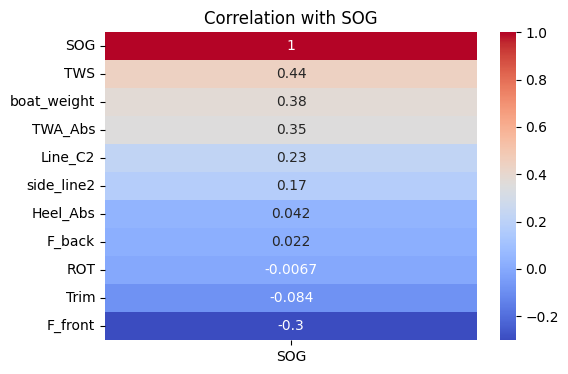


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
TWS,1372.360466,1.0,1589.405475,0.000000e+00,0.120726
boat_weight,328.017047,1.0,379.894426,2.816105e-83,0.031775
Heel_Abs,200.715430,1.0,232.459483,5.539034e-52,0.019686
Line_C2,197.871420,1.0,229.165679,2.803522e-51,0.019412
TWA_Abs,181.326459,1.0,210.004058,3.544692e-47,0.017818
F_back,175.001321,1.0,202.678571,1.318051e-45,0.017207
F_front,161.555300,1.0,187.106001,2.899904e-42,0.015906
Trim,158.703104,1.0,183.802717,1.486410e-41,0.015630
ROT,6.047947,1.0,7.004457,8.141707e-03,0.000605
side_line2,1.385295,1.0,1.604386,2.053082e-01,0.000139



Polynomial fit:
R²: 0.396

Top coefficients:
    feature  coefficient
        TWS     0.319319
boat_weight     0.050757
       Trim    -0.048508
   Heel_Abs     0.026209
    TWA_Abs     0.021815
    Line_C2     0.016298
 side_line2    -0.004188
        ROT    -0.001464
    F_front    -0.000023
     F_back     0.000014


,feature,coefficient
4,TWS,0.319319
5,boat_weight,0.050757
2,Trim,-0.048508
0,Heel_Abs,0.026209
3,TWA_Abs,0.021815
6,Line_C2,0.016298
7,side_line2,-0.004188
1,ROT,-0.001464
8,F_front,-0.000023
9,F_back,0.000014


In [23]:

full_analysis(df_numeric_downwind, target_variable="SOG",max_null_ratio= MAX_NULL_RATIO)

### III.2. Downwind: Gian vs Karl
#### III.2.1. Downwind: Gian

In [24]:
gian_data_downwind = downwind_data[((downwind_data['boat_name'] == "SenseBoard") & (downwind_data['opponent_name'] == "Karl Maeder"))]
df_numeric_gian_downwind = gian_data_downwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_gian_downwind.drop(columns=[c for c in drop_cols if c in df_numeric_gian_downwind.columns], inplace=True)
df_numeric_gian_downwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_gian_downwind)}")

Number of rows after filtering: 7826


In [25]:
print(gian_data_downwind['boat_name'].unique())
print(gian_data_downwind['opponent_name'].unique())
print(gian_data_downwind['TWA'].mean())

['SenseBoard']
['Karl Maeder']
-144.02090429338105



Initial features (10): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2', 'F_front', 'F_back']

Selected features (10): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2', 'F_front', 'F_back']

Data cleaning:
- Initial samples: 7826
- Removed samples with NaNs: 58
- Final samples: 7768

Correlation with SOG:


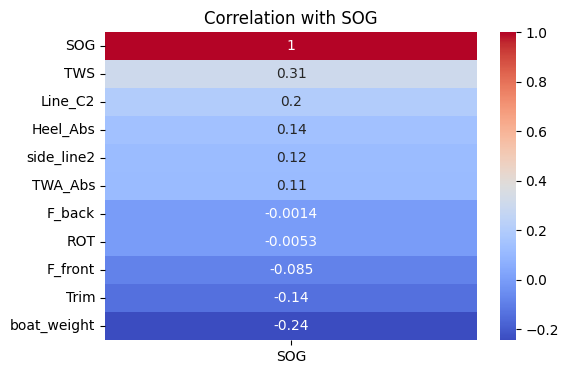


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
TWS,714.690291,1.0,850.581527,1.584903e-177,0.098818
Line_C2,119.686965,1.0,142.444248,1.497114e-32,0.018032
Heel_Abs,110.386606,1.0,131.375519,3.582000e-30,0.016654
Trim,76.043589,1.0,90.502519,2.414519e-21,0.011533
F_front,74.650031,1.0,88.843991,5.530256e-21,0.011324
TWA_Abs,24.745524,1.0,29.450639,5.909132e-08,0.003782
boat_weight,23.026048,1.0,27.404222,1.693991e-07,0.003520
F_back,17.542464,1.0,20.877989,4.970558e-06,0.002684
side_line2,2.676023,1.0,3.184842,7.436327e-02,0.000410
ROT,0.323934,1.0,0.385526,5.346787e-01,0.000050



Polynomial fit:
R²: 0.232

Top coefficients:
    feature  coefficient
        TWS     0.279134
       Trim    -0.041777
   Heel_Abs     0.023900
boat_weight    -0.023324
    Line_C2     0.015364
    TWA_Abs     0.011777
 side_line2     0.007071
        ROT    -0.000415
    F_front    -0.000018
     F_back     0.000006


,feature,coefficient
4,TWS,0.279134
2,Trim,-0.041777
0,Heel_Abs,0.023900
5,boat_weight,-0.023324
6,Line_C2,0.015364
3,TWA_Abs,0.011777
7,side_line2,0.007071
1,ROT,-0.000415
8,F_front,-0.000018
9,F_back,0.000006


In [26]:

full_analysis(df_numeric_gian_downwind, target_variable="SOG",max_null_ratio= MAX_NULL_RATIO)

#### III.2.2. Downwind: Karl

In [27]:
karl_data_downwind = downwind_data[
    (downwind_data['boat_name'] == "Karl Maeder") |
    ((downwind_data['boat_name'] == "SenseBoard") & (downwind_data['opponent_name'] == "Gian Stragiotti"))
]
df_numeric_karl_downwind = karl_data_downwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_karl_downwind.drop(columns=[c for c in drop_cols if c in df_numeric_karl_downwind.columns], inplace=True)
df_numeric_karl_downwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_karl_downwind)}")

Number of rows after filtering: 3844


In [28]:
print(karl_data_downwind['boat_name'].unique())
print(karl_data_downwind['opponent_name'].unique())
print(karl_data_downwind['TWA'].mean())

['SenseBoard']
['Gian Stragiotti']
-136.34690322580647



Initial features (10): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2', 'F_front', 'F_back']

Selected features (10): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2', 'F_front', 'F_back']

Data cleaning:
- Initial samples: 3844
- Removed samples with NaNs: 25
- Final samples: 3819

Correlation with SOG:


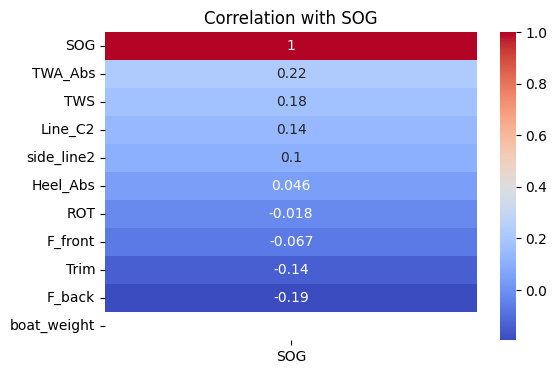


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
boat_weight,2068.453259,1.0,3004.469059,0.000000e+00,0.440960
F_front,161.501209,1.0,234.583684,1.975743e-51,0.058014
F_back,160.904602,1.0,233.717100,2.976865e-51,0.057812
Heel_Abs,86.711224,1.0,125.949759,8.877757e-29,0.032008
Trim,75.330621,1.0,109.419209,2.880241e-25,0.027924
TWA_Abs,35.525963,1.0,51.602160,8.136107e-13,0.013366
side_line2,23.862480,1.0,34.660722,4.263727e-09,0.009018
Line_C2,21.054264,1.0,30.581732,3.415918e-08,0.007965
ROT,0.908828,1.0,1.320091,2.506479e-01,0.000346
TWS,0.841992,1.0,1.223009,2.688407e-01,0.000321



Polynomial fit:
R²: 0.188

Top coefficients:
    feature   coefficient
       Trim -5.772012e-02
 side_line2 -3.784685e-02
   Heel_Abs  3.088214e-02
        TWS  2.192797e-02
    TWA_Abs  1.755553e-02
    Line_C2  9.826729e-03
        ROT -9.977695e-04
    F_front  9.672322e-05
     F_back -5.508448e-05
boat_weight -2.775558e-17


,feature,coefficient
2,Trim,-5.772012e-02
7,side_line2,-3.784685e-02
0,Heel_Abs,3.088214e-02
4,TWS,2.192797e-02
3,TWA_Abs,1.755553e-02
6,Line_C2,9.826729e-03
1,ROT,-9.977695e-04
8,F_front,9.672322e-05
9,F_back,-5.508448e-05
5,boat_weight,-2.775558e-17


In [29]:
full_analysis(df_numeric_karl_downwind, target_variable="SOG",max_null_ratio= MAX_NULL_RATIO)

#### III.2.3. Downwind: Karl vs Gian t_test

In [30]:
t_test(df_numeric_karl_downwind,df_numeric_gian_downwind)

T-statistic: -69.413, p-value: 0.000000000000000
The difference is statistically significant, keeping data split.


### III.3. Downwind: Master vs Slave
#### III.3.1 Downwind Master

In [31]:
master_data_downwind = downwind_data[downwind_data['boat_role'] == "master"]
df_numeric_master_downwind = master_data_downwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_master_downwind.drop(columns=[c for c in drop_cols if c in df_numeric_master_downwind.columns], inplace=True)
df_numeric_master_downwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_master_downwind)}")

Number of rows after filtering: 6136



Initial features (10): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2', 'F_front', 'F_back']

Selected features (10): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2', 'F_front', 'F_back']

Data cleaning:
- Initial samples: 6136
- Removed samples with NaNs: 49
- Final samples: 6087

Correlation with SOG:


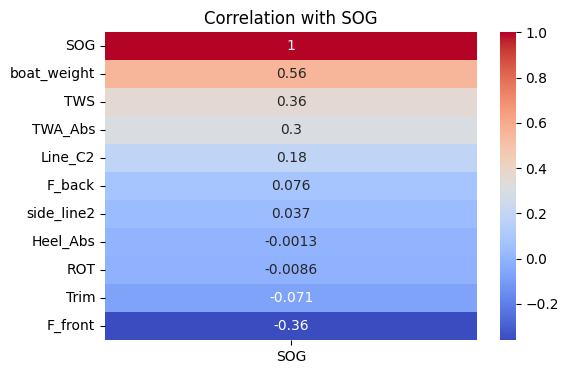


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
boat_weight,454.613648,1.0,686.499463,1.867159e-143,0.101516
TWS,228.881294,1.0,345.627295,4.449936e-75,0.053822
F_back,148.208869,1.0,223.806103,1.017915e-49,0.035526
side_line2,104.593257,1.0,157.943376,8.846266e-36,0.025336
TWA_Abs,90.698475,1.0,136.961252,2.659724e-31,0.022044
F_front,86.566793,1.0,130.722114,5.757158e-30,0.021061
Line_C2,73.125708,1.0,110.425104,1.309888e-25,0.017850
Heel_Abs,59.044340,1.0,89.161221,5.067872e-21,0.014462
Trim,51.693933,1.0,78.061574,1.288815e-18,0.012685
ROT,2.159477,1.0,3.260967,7.099675e-02,0.000536



Polynomial fit:
R²: 0.442

Top coefficients:
    feature  coefficient
        TWS     0.181217
boat_weight     0.086583
 side_line2    -0.048572
       Trim    -0.036913
   Heel_Abs     0.019307
    TWA_Abs     0.019109
    Line_C2     0.013380
        ROT    -0.001226
    F_front    -0.000023
     F_back     0.000018


,feature,coefficient
4,TWS,0.181217
5,boat_weight,0.086583
7,side_line2,-0.048572
2,Trim,-0.036913
0,Heel_Abs,0.019307
3,TWA_Abs,0.019109
6,Line_C2,0.013380
1,ROT,-0.001226
8,F_front,-0.000023
9,F_back,0.000018


In [32]:
full_analysis(df_numeric_master_downwind, target_variable="SOG",max_null_ratio= MAX_NULL_RATIO)

#### III.3.2 Downwind Slave

In [33]:
slave_data_downwind = downwind_data[downwind_data['boat_role'] == "slave"]
df_numeric_slave_downwind = slave_data_downwind.select_dtypes(include=["float64", "int64"]).copy()
df_numeric_slave_downwind.drop(columns=[c for c in drop_cols if c in df_numeric_slave_downwind.columns], inplace=True)
df_numeric_slave_downwind.dropna(subset=["SOG"], inplace=True)
print(f"Number of rows after filtering: {len(df_numeric_slave_downwind)}")

Number of rows after filtering: 5534



Initial features (10): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2', 'F_front', 'F_back']

Selected features (10): ['Heel_Abs', 'ROT', 'Trim', 'TWA_Abs', 'TWS', 'boat_weight', 'Line_C2', 'side_line2', 'F_front', 'F_back']

Data cleaning:
- Initial samples: 5534
- Removed samples with NaNs: 34
- Final samples: 5500

Correlation with SOG:


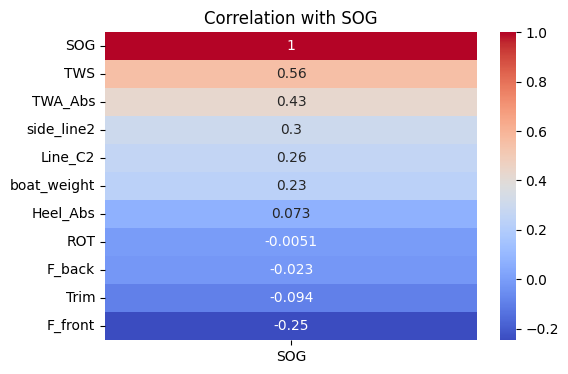


ANOVA:


,sum_sq,df,F,PR(>F),partial_eta_sq
TWS,1307.179765,1.0,1526.330524,8.378151e-295,0.217571
TWA_Abs,176.832350,1.0,206.478574,5.456323e-46,0.036253
Trim,115.726049,1.0,135.127704,7.102676e-31,0.024026
side_line2,97.197037,1.0,113.492274,3.033354e-26,0.020257
Heel_Abs,96.651087,1.0,112.854794,4.156534e-26,0.020146
boat_weight,63.042030,1.0,73.611126,1.222956e-17,0.013233
Line_C2,44.381438,1.0,51.822056,6.893944e-13,0.009353
F_back,5.828509,1.0,6.805668,9.111537e-03,0.001238
ROT,5.084637,1.0,5.937085,1.485709e-02,0.001080
F_front,0.816881,1.0,0.953832,3.287887e-01,0.000174



Polynomial fit:
R²: 0.490

Top coefficients:
    feature  coefficient
        TWS     0.481770
       Trim    -0.062901
 side_line2     0.053382
    TWA_Abs     0.038312
boat_weight     0.033192
   Heel_Abs     0.027173
    Line_C2     0.011699
        ROT    -0.001922
     F_back     0.000004
    F_front    -0.000002


,feature,coefficient
4,TWS,0.481770
2,Trim,-0.062901
7,side_line2,0.053382
3,TWA_Abs,0.038312
5,boat_weight,0.033192
0,Heel_Abs,0.027173
6,Line_C2,0.011699
1,ROT,-0.001922
9,F_back,0.000004
8,F_front,-0.000002


In [34]:
full_analysis(df_numeric_slave_downwind, target_variable="SOG",max_null_ratio= MAX_NULL_RATIO)

#### III.3.3. Downwind: Master vs Slave t_test

In [35]:
t_test(df_numeric_master_downwind,df_numeric_slave_downwind)

T-statistic: 9.267, p-value: 0.000000000000000
The difference is statistically significant, keeping data split.
